Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import re

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

Analysis of Data

In [ ]:
data = pd.read_csv('Economic News.csv', encoding = 'ISO-8859-1')
display(data.shape)

(8000, 15)

In [ ]:
data["relevance"].value_counts()

relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64

In [ ]:
data = data[data.relevance != "not sure"]
data.shape

(7991, 15)

In [ ]:
data["relevance"].value_counts()/data.shape[0]

relevance
no     0.8223
yes    0.1777
Name: count, dtype: float64

In [ ]:
fig = go.Figure([go.Bar(x=data['relevance'].value_counts().index, y=data['relevance'].value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

Text Pre-processing

In [ ]:
data['relevance'] = data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0
data = data[["text","relevance"]] # taking text input and output variable as relevance
data = data[:1000]
data.shape

(1000, 2)

In [ ]:
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [ ]:
data['text'][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

Text cleaning

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

stopwords = _stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ")
    doc = doc.replace("-", " ")
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [ ]:
import nltk
nltk.download('wordnet')
clean(data['text'][0])

[nltk_data] Downloading package wordnet to /root/nltk_data...


'new york yields certificates deposit offered major banks dropped tenth percentage point latest week reflecting overall decline short term rates br small denomination consumer cds sold directly banks average yield month deposits fell week ended yesterday according bank survey money markets information service br month consumer deposits average yield sank week according banks survey new york paying small denomination declines somewhat smaller year consumer cds eased said br yields month month bills sold s auction plummeted fifth percentage point previous week respectively'

In [ ]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal online br morning brief lo...,0
2,effort achieve banking reform negotiators admi...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked dollar s tone trade...,1


TF-IDF

In [ ]:
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [ ]:
X = docs
y = data['relevance']
print(X.shape, y.shape)

(1000, 12523) (1000,)


In [ ]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

Train-Test Split

In [ ]:
SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 12523) (800,)
(200, 12523) (200,)


Logistic Regression Classifier

In [ ]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 522 ms, sys: 320 ms, total: 841 ms
Wall time: 817 ms

Training Accuracy score: 0.81375
Testing Accuracy score: 0.765


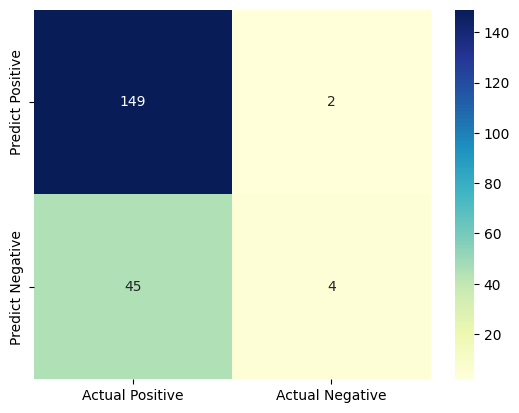

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.77      0.99      0.86       151
    relevant       0.67      0.08      0.15        49

    accuracy                           0.77       200
   macro avg       0.72      0.53      0.50       200
weighted avg       0.74      0.77      0.69       200



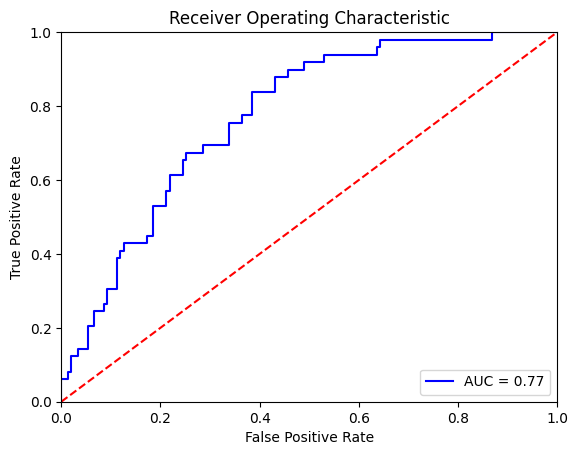

In [ ]:
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Support Vector Machines

In [ ]:
svc =  LinearSVC(class_weight='balanced')
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 57.5 ms, sys: 0 ns, total: 57.5 ms
Wall time: 58.6 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.75


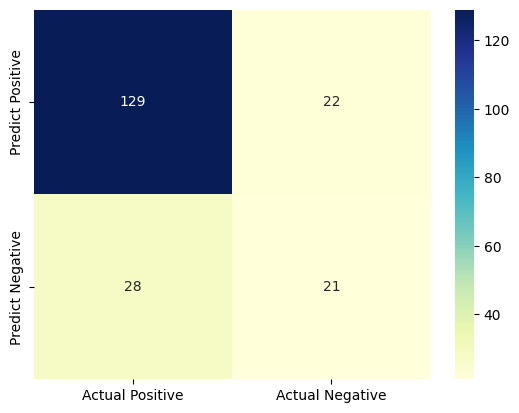

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.82      0.85      0.84       151
    relevant       0.49      0.43      0.46        49

    accuracy                           0.75       200
   macro avg       0.66      0.64      0.65       200
weighted avg       0.74      0.75      0.74       200



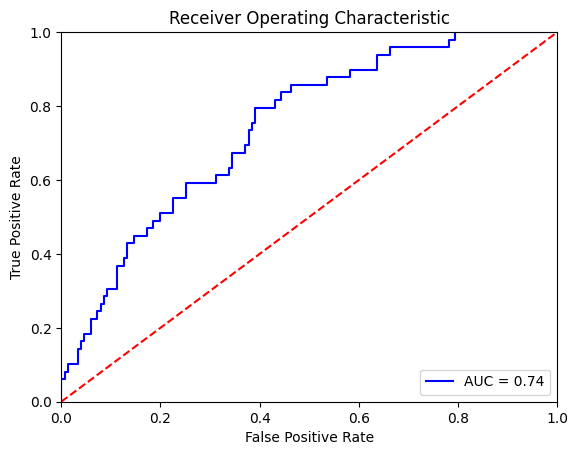

In [ ]:
probs = svc._predict_proba_lr(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 1.4 s, sys: 15.8 ms, total: 1.41 s
Wall time: 1.41 s

Training Accuracy score: 1.0
Testing Accuracy score: 0.71


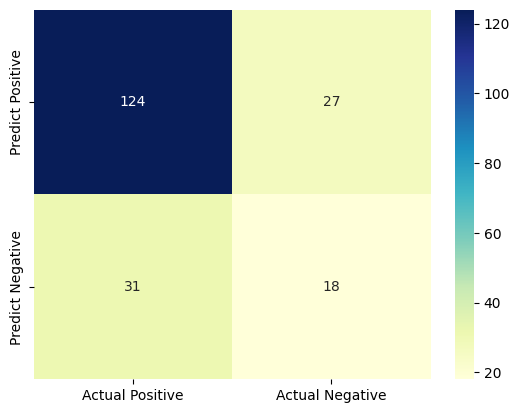

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.80      0.82      0.81       151
    relevant       0.40      0.37      0.38        49

    accuracy                           0.71       200
   macro avg       0.60      0.59      0.60       200
weighted avg       0.70      0.71      0.71       200



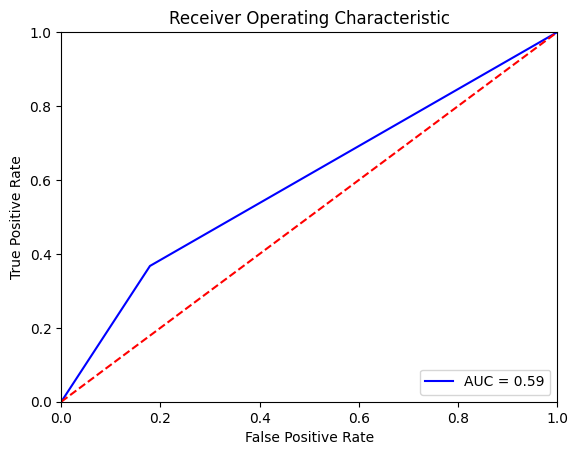

In [ ]:
probs = dt.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Balance the data

In [ ]:
# Import necessary libraries
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
# Oversampling
# Print the original class distribution
print(f'Original class distribution: {Counter(y)}')

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and resample the data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Print the resampled class distribution
print(f'Resampled class distribution: {Counter(y_resampled)}')

Original class distribution: Counter({0: 757, 1: 243})
Resampled class distribution: Counter({1: 757, 0: 757})


In [ ]:
X = X_resampled
y = y_resampled
print(X.shape, y.shape)

(1514, 12523) (1514,)


In [ ]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [ ]:
SEED=123
X_train_resampled,X_test_resampled,y_train_resampled,y_test_resampled=train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=SEED, stratify=y)
print(X_train_resampled.shape, y_train_resampled.shape)
print(X_test_resampled.shape, y_test_resampled.shape)

(1211, 12523) (1211,)
(303, 12523) (303,)


LR (oversampling)

In [ ]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_resampled, y_resampled)

y_pred_train_resampled = lr.predict(X_resampled)
y_pred_test_resampled = lr.predict(X_test_resampled)
print("\nTraining Accuracy score:",accuracy_score(y_resampled, y_pred_train_resampled))
print("Testing Accuracy score:",accuracy_score(y_test_resampled, y_pred_test_resampled))


CPU times: user 1.07 s, sys: 470 ms, total: 1.54 s
Wall time: 1.72 s

Training Accuracy score: 0.928005284015852
Testing Accuracy score: 0.9372937293729373


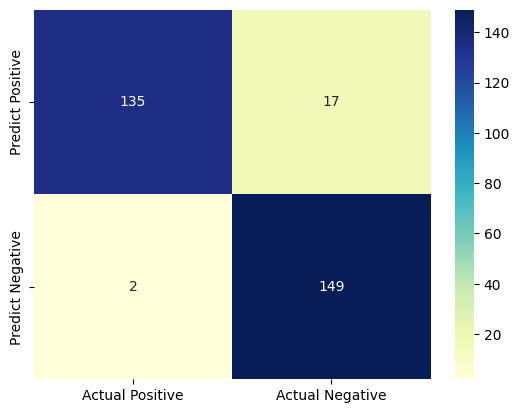

In [ ]:
cm = confusion_matrix(y_test_resampled, y_pred_test_resampled)
#print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
print(classification_report(y_test_resampled, y_pred_test_resampled, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.99      0.89      0.93       152
    relevant       0.90      0.99      0.94       151

    accuracy                           0.94       303
   macro avg       0.94      0.94      0.94       303
weighted avg       0.94      0.94      0.94       303



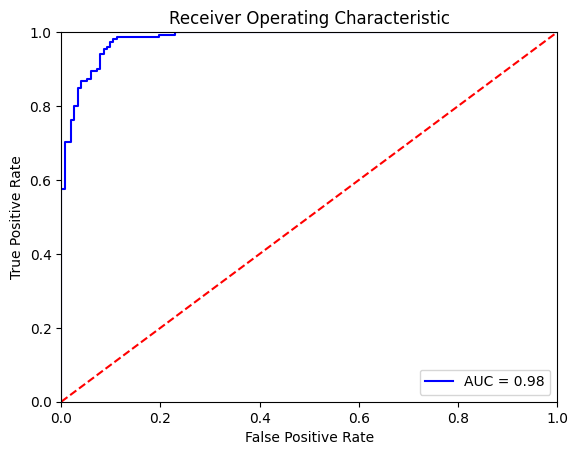

In [ ]:
probs = lr.predict_proba(X_test_resampled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_resampled, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Support Vector Machines (Resampled)

In [ ]:
svc =  LinearSVC(class_weight='balanced')
%time svc.fit(X_train_resampled, y_train_resampled)

y_pred_train_resampled = svc.predict(X_train_resampled)
y_pred_test_resampled = svc.predict(X_test_resampled)
print("\nTraining Accuracy score:",accuracy_score(y_train_resampled, y_pred_train_resampled))
print("Testing Accuracy score:",accuracy_score(y_test_resampled, y_pred_test_resampled))

CPU times: user 129 ms, sys: 2.42 ms, total: 131 ms
Wall time: 195 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.8976897689768977


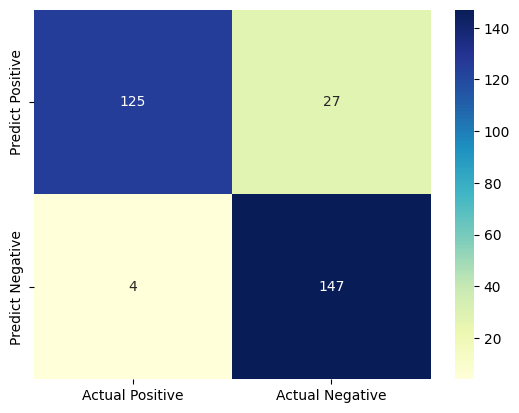

In [ ]:
cm = confusion_matrix(y_test_resampled, y_pred_test_resampled)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
print(classification_report(y_test_resampled, y_pred_test_resampled, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.97      0.82      0.89       152
    relevant       0.84      0.97      0.90       151

    accuracy                           0.90       303
   macro avg       0.91      0.90      0.90       303
weighted avg       0.91      0.90      0.90       303



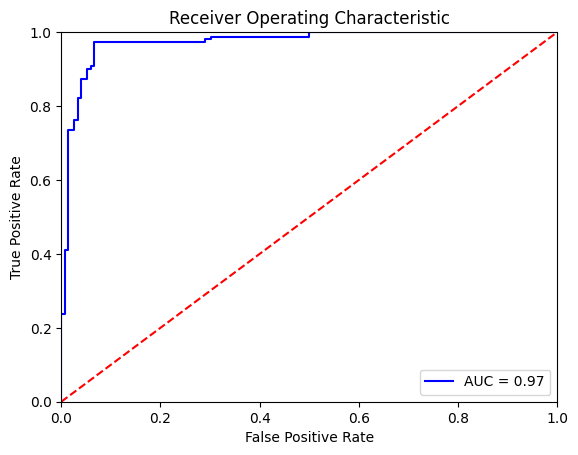

In [ ]:
probs = svc._predict_proba_lr(X_test_resampled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_resampled, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Decision Tree Classifier (Resampled)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_resampled, y_train_resampled)

y_pred_train_resampled = dt.predict(X_train_resampled)
y_pred_test_resampled = dt.predict(X_test_resampled)
print("\nTraining Accuracy score:",accuracy_score(y_train_resampled, y_pred_train_resampled))
print("Testing Accuracy score:",accuracy_score(y_test_resampled, y_pred_test_resampled))

CPU times: user 1.62 s, sys: 16.6 ms, total: 1.64 s
Wall time: 1.76 s

Training Accuracy score: 1.0
Testing Accuracy score: 0.8745874587458746


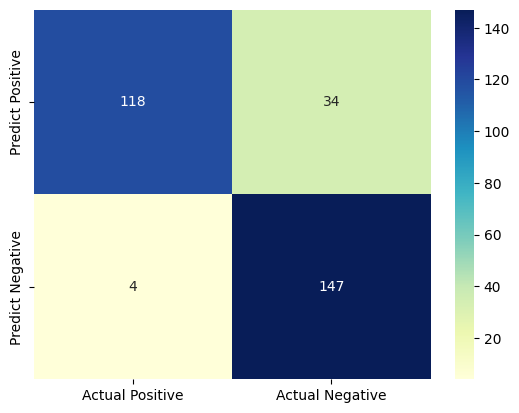

In [ ]:
cm = confusion_matrix(y_test_resampled, y_pred_test_resampled)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
print(classification_report(y_test_resampled, y_pred_test_resampled, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.97      0.78      0.86       152
    relevant       0.81      0.97      0.89       151

    accuracy                           0.87       303
   macro avg       0.89      0.87      0.87       303
weighted avg       0.89      0.87      0.87       303



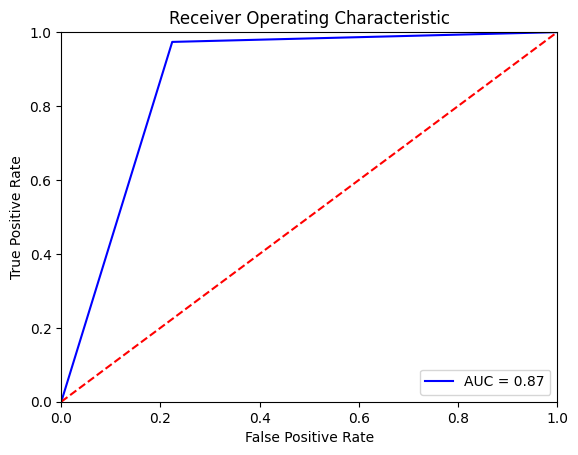

In [ ]:
probs = dt.predict_proba(X_test_resampled)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_resampled, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()